In [1]:
from PIL import Image
from IPython.display import display

def height2image (Z, terrain=None ):
    # converts a heightmap z into a PIL image
    # for terrain=None, this is a black and white image with white for Z[x,y]=1 and black for Z[x,y]=0
    # otherwise, the values in terrain are used as thresholds between sea and beach, beach and grass, etc
    image = {}
    for pos in Z:
        if terrain:
            if Z[pos]<terrain[0]:
                image[pos] = (50,120,200)
            elif Z[pos]<terrain[1]:
                image[pos] = (220,220,10)
            elif Z[pos]<terrain[2]:
                image[pos] = (100,200,0)
            elif Z[pos]<terrain[3]:
                image[pos] = (75,150,0)
            elif Z[pos]<terrain[4]:
                 image[pos] = (200,200,200)  
            else:
                image[pos] = (255,255,255)
        else:
            z = int(255*Z[pos])
            image[pos] = (z,z,z)
            
    X = max(Z.keys())[0]+1
    Y = max(Z.keys())[1]+1
    img = Image.new('RGB',(X,Y))  
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]
    return img

def plot_height (Z,terrain=[5/16,6/16,9/16,12/16,14/16],zoom=None):
    # display a heightmap as the above image
    # displayed image is a terrain map by default
    img = height2image(Z,terrain=terrain)
    if zoom:
        img = img.resize((zoom*img.size[0],zoom*img.size[0]), Image.LANCZOS)
    img.save('temp.png')
    display(Image.open('temp.png'))

In [2]:
from opensimplex import OpenSimplex
import random

def simplex(L,period):
    # create a heightmap for an L[0]xL[1] image using simplex noise
    gen = OpenSimplex(seed=random.randint(0,10**20))
    Z = {}
    for x in range(L[0]):
        for y in range(L[1]):
            xx = period[0]*(x/L[0]-0.5)
            yy = period[1]*(y/L[1]-0.5)
            Z[x,y] = gen.noise2(xx,yy)/2 + 0.5     
    return Z

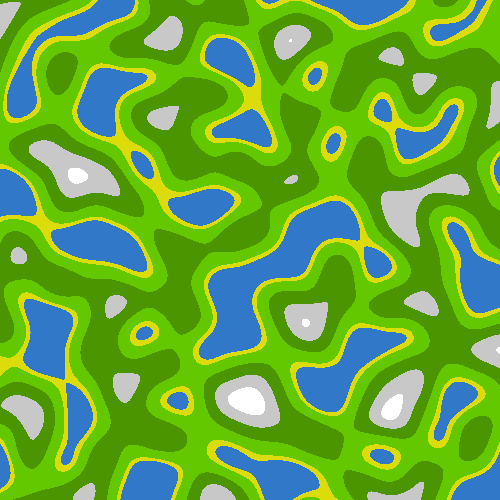

In [3]:
Zlow = simplex([500,500],[10,10])
plot_height( Zlow )

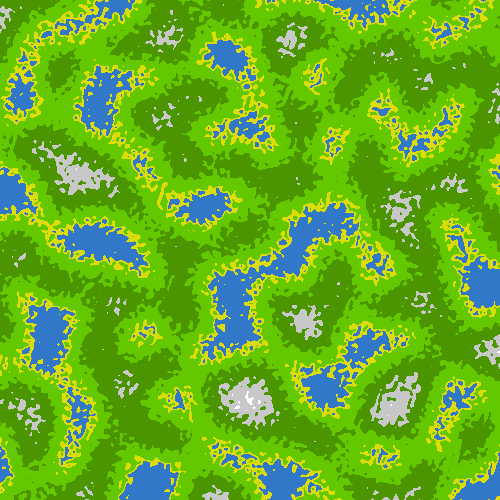

In [4]:
Zhigh = simplex([500,500],[100,100])
Z = { pos: 0.8*Zlow[pos] + 0.2*Zhigh[pos] for pos in Zhigh }
plot_height( Z )

In [5]:
n = 10
shots = 4**n

In [6]:
import numpy as np

def get_L(n):
    # determine the size of the grid corresponding to n qubits
    Lx = int(2**np.ceil(n/2))
    Ly = int(2**np.floor(n/2))
    return [Lx,Ly]

def make_grid(n):
    # make a dictionary for which every point in the grid is assigned a unique n bit string
    # these are such that '0'*n is in the center, and each string neighbours only its neighbours on the hypercube
    
    [Lx,Ly] = get_L(n)

    strings = {}
    for y in range(Ly):
        for x in range(Lx):
            strings[(x,y)] = ''

    for (x,y) in strings:
        for j in range(n):
            if (j%2)==0:
                xx = np.floor(x/2**(j/2))
                strings[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + strings[(x,y)]
            else:
                yy = np.floor(y/2**((j-1)/2))
                strings[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + strings[(x,y)]

    center = '0'*n
    current_center = strings[ ( int(np.floor(Lx/2)),int(np.floor(Ly/2)) ) ]
    diff = ''
    for j in range(n):
        diff += '0'*(current_center[j]==center[j]) + '1'*(current_center[j]!=center[j])
    for (x,y) in strings:
            newstring = ''
            for j in range(n):
                newstring += strings[(x,y)][j]*(diff[j]=='0') + ('0'*(strings[(x,y)][j]=='1')+'1'*(strings[(x,y)][j]=='0'))*(diff[j]=='1')
            strings[(x,y)] = newstring
            
    grid = {}
    for y in range(Ly):
        for x in range(Lx):
            grid[strings[(x,y)]] = (x,y)
    
    return strings

In [7]:
def normalize_height(Z):
    # scales heights so that the maximum is 1 and the minimum is 0
    maxZ = max(Z.values())
    minZ = min(Z.values())
    for pos in Z:
        Z[pos] = (Z[pos]-minZ)/(maxZ-minZ)
    return Z

def counts2height(counts,grid,log=False):
    # set the height of a point to be the counts value of the corresponding bit string (or the logarithm) and normalize
    Z = {}
    for pos in grid:
        try:
            Z[pos] = counts[grid[pos]]
        except:
            Z[pos] = 0
    if log:
        for pos in Z:
            Z[pos] = max(Z[pos],1/len(grid)**2)
            Z[pos] = np.log( Z[pos] )/np.log(2)
    Z = normalize_height(Z)    
    return Z

In [8]:
def height2state(Z,grid):
    # converts a heightmap into a quantum state
    N = len(grid)
    state = [0]*N

    for pos in Z:
        state[ int(grid[pos],2) ] = np.sqrt( Z[pos] ) # amplitude is square root of height value
    R = sum(np.absolute(state)**2)
    state = [amp / np.sqrt(R) for amp in state] # amplitudes are normalized
    return state

In [9]:
def state2counts (state,shots=None):
    N = len(state)
    n = int(np.log2(N))
    if shots is None:
        shots = N**2
    counts = {}
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(state[j])**2 * shots # square amplitudes to get probabilities
    return counts

In [10]:
L = get_L(n)
Z = simplex(L,[10,10])

grid = make_grid(n)
state = height2state(Z,grid)

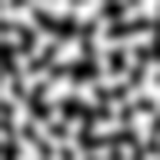

In [11]:
counts = state2counts(state)
Z = counts2height(counts,grid)
plot_height(Z, terrain=None, zoom=5)

In [18]:
import ipywidgets as widgets
from ipywidgets import Checkbox, ToggleButton, Layout, HBox, VBox

def get_boxes(L,value=True):

    width = str(500/L[0])+'px'
    height = str(500/L[1])+'px'

    box = {}
    for y in range(L[1]):
        for x in range(L[0]):
            box[x,y] = widgets.ToggleButton(value=value,button_style='',layout=Layout(width=width, height=height))
            
    return box

In [17]:
box = get_boxes(L)

VBox([ HBox([ box[x,y] for x in range(L[0]) ]) for y in range(L[1]) ])

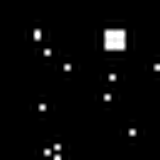

In [22]:
def flat_height(L):
    # create height map that is 0 everywhere
    Z ={}
    for x in range(L[0]):
        for y in range(L[1]):
            Z[x,y] = 0
    return Z

Z = flat_height(L)
for y in range(L[1]):
    for x in range(L[0]):
        if box[x,y].value==False:
            Z[x,y] = 1
            
plot_height( Z, terrain=None, zoom=5 )

In [24]:
from qiskit import *
import time
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider

def quantum_tartan (seed,theta,grid=None,shots=1,log=True):
        
    n = int(np.log2( len(seed) ))
        
    if grid is None:
        grid = make_grid(n)

    state = height2state(seed,grid)

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)
    qc.initialize(state,q)
    qc.ry(2*np.pi*theta,q)
    qc.save_statevector()
    
    if shots>1:
        try:
            provider = IBMProvider()
            backend = provider.backend
        except:
            print('An IBMQ account is required to use a real device\nSee https://github.com/Qiskit/qiskit-terra/blob/master/README.md')
    else:
        backend = AerSimulator(method='statevector')

    if shots>1:
        c = ClassicalRegister(n)
        qc.add_register(c)
        qc.measure(q,c)
    
    start = time.time()
    print('Quantum job initiated on', backend.name)
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=shots)
    end = time.time()
    print('Quantum job complete after',int(end-start),'seconds')
    

    if shots>1:
        counts = job.result().get_counts()
    else:
        counts = state2counts( job.result().get_statevector() )
        
    Z = counts2height(counts,grid,log=log)   
    
    return Z, grid

Quantum job initiated on aer_simulator_statevector
Quantum job complete after 1 seconds


C:\Users\cwq\AppData\Local\Temp\ipykernel_55944\3106717458.py:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  N = len(state)


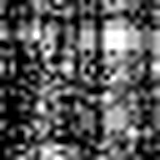

In [25]:
Z, grid = quantum_tartan(Z,0.01)
plot_height( Z, terrain=None, zoom=5 )

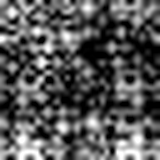

In [26]:
def shuffle_grid(grid):
    
    n = int( np.log(len(grid))/np.log(2) )
    
    order = [j for j in range(n)]
    random.shuffle(order)
    
    new_grid = {}
    for pos in grid:
        new_string = ''
        for j in order:
            new_string = grid[pos][j] + new_string
        new_grid[pos] = new_string
    
    return new_grid

def shuffle_height (Z,grid):
    
    new_grid = shuffle_grid(grid)
    new_Z = {}
    for pos in Z:
        string = grid[pos] 
        new_pos = list(new_grid.keys())[ list(new_grid.values()).index( string ) ]
        new_Z[new_pos] = Z[pos]
        
    return new_Z,new_grid


Z,grid = shuffle_height(Z,grid)
plot_height( Z, terrain=None, zoom=5 )

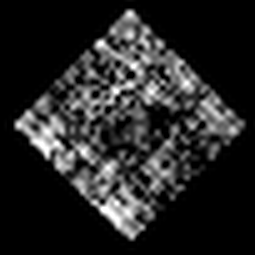

In [27]:
def rotate_height (Z,theta):
    # rotate height Z by angle theta
    L = list(max(Z))
    mid = [(L[j]+1)/2 for j in range(2)]
    
    Lr = [ int( 1.6*(L[j]+1) ) for j in range(2) ]
    midr = [Lr[j]/2 for j in range(2)]
    
    Zr = flat_height(Lr)
    
    for pos in Zr:
        
        d = [ pos[j]-midr[j] for j in range(2) ]
        
        x = int( d[0]*np.cos(theta*np.pi) + d[1]*np.sin(theta*np.pi) + mid[0] )
        y = int( -d[0]*np.sin(theta*np.pi) + d[1]*np.cos(theta*np.pi) + mid[1] )
        
        if (x,y) in Z:
            Zr[pos] = Z[x,y]
        else:
            Zr[pos] = 0
        
    return Zr


plot_height( rotate_height(Z,0.25), terrain=None, zoom=5 )

In [28]:
start = time.time()

samples = 300
tartans = []
for j in range(samples):
    randZ,_ =  shuffle_height(Z,grid)
    randZ = rotate_height(randZ,random.random())
    tartans.append( randZ )
    
end = time.time()
print('Generation of',samples,'samples took',int(end-start),'seconds')

Generation of 300 samples took 10 seconds


In [29]:
reduced_size = [10,10]
peak_box = get_boxes(reduced_size)
VBox([ HBox([ peak_box[x,y] for x in range(reduced_size[0]) ]) for y in range(reduced_size[1]) ])

In [30]:
valley_box = get_boxes(reduced_size,value=False)
VBox([ HBox([ valley_box[x,y] for x in range(reduced_size[0]) ]) for y in range(reduced_size[1]) ])

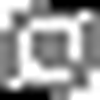

In [31]:

Zs = {}
for y in range(reduced_size[1]):
    for x in range(reduced_size[0]):
        if peak_box[x,y].value==False:
            Zs[x,y] = 1
        elif valley_box[x,y].value==True:
            Zs[x,y] = 0
        else:
            Zs[x,y] = 0.5
            
plot_height( Zs , terrain=None, zoom=10 )

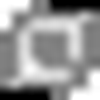

In [32]:
def blur(Zs,reduced_size,steps=2):
    for j in range(steps):
        for offset in [0,1]:
            for y in range(1,reduced_size[1]-1):
                for x in range(1+(offset+y)%2,reduced_size[0]-1+(offset+y)%2,2):
                    Zs[x,y] = ( Zs[x,y] + (Zs[x+1,y] + Zs[x-1,y] + Zs[x,y+1] + Zs[x,y-1])/4 )/2
    return Zs

Zs = blur(Zs,reduced_size,steps=1)
plot_height( Zs , terrain=None, zoom=10 )

In [33]:
def islands(size,Zs,tartans):
    # height map of created by combining the quantum tartans of `tartans` with the basic map features.
    Z = flat_height(size)
        
    tsize = max(tartans[0])
    
    for tartan in tartans:  
        unchosen = True
        while unchosen:
            x0 = random.choice(range(size[0]))
            y0 = random.choice(range(size[1]))
            if random.random()<Zs[int(x0*(max(Zs.keys())[0]+1)/size[0]),int(y0*(max(Zs.keys())[1]+1)/size[1])]:
                unchosen = False

        for (x,y) in tartan:
            xx = x-int(tsize[0]/2)+x0
            yy = y-int(tsize[1]/2)+y0
            if (xx,yy) in Z:
                    Z[xx,yy] += tartan[x,y]
                
    Z = normalize_height(Z)

    return Z

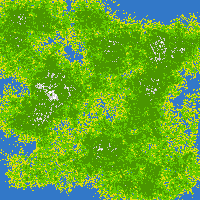

In [34]:
size = [200,200]
Z_islands = islands(size,Zs,tartans)
plot_height( Z_islands, terrain=[2/16,3/16,5/16,10/16,12/16] )

In [35]:
def make_blocks(Z,terrain=[2/16,3/16,5/16,10/16,12/16],height=24,depth=12):
    # make a dictionary that determines which material exists at each 3D position
    # also returns mins and maxs of all three coordinates in `mins` and `maxs`
    def addBlocks( blocks, x1,h1,y1, x2,h2,y2, block ):
        # add a blocks of a given type for a given range of coordinates
        for x in range(x1,x2+1):
            for y in range(y1,y2+1):
                for h in range(h1,h2+1):
                    blocks[x,h,y] = block
    
    def addTreeBlocks( blocks, x,h,y, rnd ):
        #Makes a tree, rooted at the specified position'''
        for j in range(1,6):
            blocks[x,h+j,y] = 'tree'
        for xx in range(x-3,x+4):
            for yy in range(y-3,y+4):
                for hh in range(h+5,h+11):
                    d = (xx-x)**2+(yy-y)**2+(hh-h-6)**2 + 0.1
                    if d<8:
                        blocks[xx,hh,yy] = 'leaves'
        xx = choose([x-1,x+1],rnd)
        yy = choose([y-1,y+1],rnd)
        blocks[xx,h+5,yy] = 'tree'
        blocks[xx,h+4,yy] = 'torch'
                              
    def choose( options, rnd ):
        return options [ int(round(rnd*( len(options)-1 ))) ]
    
    
    sea_level = int( depth+terrain[0]*height+1 )
    
    choosing = True
    while choosing:
        spawn = random.choice( list(Z.keys()) )
        if Z[spawn]>terrain[0]:
            choosing = False
    spawn = [spawn[0],depth+height,spawn[1]]
    
    blocks = {}
    (Xmin,Hmin,Ymin) = (0,0,0)
    (Xmax,Hmax,Ymax) = (0,0,0)
    for (X,Y) in Z:
        
        Hfloat = depth + Z[X,Y]*height
        H = int( Hfloat ) # height for a block
        rnd = Hfloat-H # value from 0 to 1 that we can use for randomness
        
        Xmin = min(Xmin,X); Ymin = min(Ymin,Y); Hmin = min(Hmin,H)
        Xmax = max(Xmax,X); Ymax = max(Ymax,Y); Hmax = max(Hmax,H)
        
        # First we make a cavern, which is most spacious under hills
        
        Hm = int( (1-Z[X,Y])*depth/2 ) # height for stalagtites
        Ht = int( depth - (1-Z[X,Y])*depth/2 ) #height at which stalagmites begin
        
        if Z[X,Y]<terrain[0]:
            minerals = ['diamondblock','goldblock'] # most precious minerals in hard to reach places
        else:
            minerals = ['stone','stone','stone_with_coal','stone_with_iron','stone_with_copper','stone_with_tin','stone_with_gold','stone_with_diamond']
        stone_m = choose(minerals,rnd)
        stone_t = choose(minerals,1-rnd)
   
        if (1-Z[X,Y])<terrain[0]: # the very bottom of the cavern has lava
            blocks[X,0,Y] = stone_m
            blocks[X,1,Y] = 'lava_source'
        else: # otherwise a mineral
            addBlocks( blocks, X,0,Y, X,Hm,Y, stone_m )
            
        if Z[X,Y]<terrain[4]: # the roof is always a mineral
            addBlocks( blocks, X,Ht,Y, X,depth,Y, stone_t )
        
        if rnd<0.005 and Z[X,Y]>terrain[0] and Z[X,Y]<terrain[4]:
            blocks[X,Ht-1,Y] = 'torch'
                        
        if Z[X,Y]<terrain[0]: # sand at H and then water up to sea level
            addBlocks( blocks, X,depth,Y, X,H,Y, 'sand' )
            addBlocks( blocks, X,H+1,Y, X,sea_level,Y, 'water_source' )
        elif Z[X,Y]<terrain[1]: # sand
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'sand'
            blocks[X,H+1,Y] = 'sand'
        elif Z[X,Y]<terrain[2]: # grass with trees
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'dirt_with_grass'
            blocks[X,H+1,Y] = 'dirt_with_grass'
            if rnd<0.025:
                addTreeBlocks( blocks, X,H,Y, rnd )
            else:
                blocks[X,H+2,Y] = choose(['fern_1','marram_grass_1','marram_grass_2','marram_grass_3'],rnd)
        elif Z[X,Y]<terrain[3]: # grass with ferns
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            blocks[X,H,Y] = 'dirt_with_grass'
            blocks[X,H+1,Y] = 'dirt_with_grass'
            blocks[X,H+2,Y] = choose(['fern_1','fern_2','fern_3','marram_grass_1'],rnd)
        elif Z[X,Y]<terrain[4]: # mixture of grass and stone
            addBlocks( blocks, X,depth+1,Y, X,H-1,Y, 'stone' )
            if rnd<1/3:
                blocks[X,H,Y] = 'dirt_with_grass'
                blocks[X,H+1,Y] = 'dirt_with_grass'
            else:
                blocks[X,H,Y] = 'stone'
                blocks[X,H+1,Y] = 'stone'
        elif H==(depth + terrain[4]*height): # just stone, with a random bit of additional height
            H += int(height*rnd/10)
            addBlocks( blocks, X,depth+1,Y, X,H+1,Y, 'stone' )
        elif Z[X,Y]==1:
            blocks[X,H,Y] = 'torch'
                
        mins = (Xmin,Hmin,Ymin)
        maxs = (Xmax,Hmax,Ymax)
        
    return blocks, spawn, mins, maxs
    
def save_blocks(blocks,spawn,mins,maxs,filename='blocks.csv'):
    # saves a dictionary of the form created by the above function as a csv file
    with open(filename, 'w') as file:
        file.write( str(mins[0])+','+str(mins[1])+','+str(mins[2])+',min,\n' )
        file.write( str(maxs[0])+','+str(maxs[1])+','+str(maxs[2])+',max,\n' )
        file.write( str(spawn[0])+','+str(spawn[1])+','+str(spawn[2])+',player,\n' )
        for (x,h,y) in blocks:
            file.write( str(x)+','+str(h)+','+str(y)+','+blocks[x,h,y]+',\n' )

In [36]:
blocks, spawn, mins, maxs = make_blocks( Z_islands )
save_blocks( blocks, spawn, mins, maxs )